# Отток клиентов

**Описание проекта**

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Описание данных**

`RowNumber` — индекс строки в данных

`CustomerId` — уникальный идентификатор клиента

`Surname` — фамилия

`CreditScore` — кредитный рейтинг

`Geography` — страна проживания

`Gender` — пол

`Age` — возраст

`Tenure` — сколько лет человек является клиентом банка

`Balance` — баланс на счёте

`NumOfProducts` — количество продуктов банка, используемых клиентом

`HasCrCard` — наличие кредитной карты

`IsActiveMember` — активность клиента

`EstimatedSalary` — предполагаемая зарплата

`Exited` — факт ухода клиента

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

Импортируем необходимые библиотеки и загрузим датасет в переменную *data*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [2]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data['Tenure'].isna().sum()

909

In [4]:
data['Surname'].value_counts()

Smith      32
Martin     29
Scott      29
Walker     28
Brown      26
           ..
Flores      1
Cobb        1
Buckner     1
Peyser      1
Duke        1
Name: Surname, Length: 2932, dtype: int64

In [5]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Наш датасет состоит из 10000 объектов, каждый из которых описан 14 признаками. Исходя из условия, целевым является признак `Exited`, определяющий факт ухода клиента. 
Наблюдаются как категориальны, так и колличественные признаки. Необходима техника прямого кодирования.
Признак `Tenure` (количество недвижимости у клиента) содержит 909 пропусков. Логично предположить, что пропуски появились ввиду отсутствия недвижимости у клиентов.
1. Столбец `RowNumber` не несет в себе ценной информации для обучения модели, а всего лишь дублирует значения стандартного датафрейма, поэтому столбец удалим.
2. Данные столбца `CustomerId` являются идентификаторами клиентов. Так же не несет ценности для модели и будет удален.
3. Столбец `Surname` содержит 2932 уникальных значения, но не несет ценности для качества будующей модели. Столбец можно удалить.

**1.1 Удаление лишних столбцов**

In [6]:
data_new = data.drop(['RowNumber','CustomerId', 'Surname'], axis=1)
data_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
ОК, эти столбцы "в сад"

**1.2 Замена пропусков**

In [7]:
data_new['Tenure'] = data_new['Tenure'].fillna(0.0)

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
решение понятно, но обоснования ему нет(((( Почему именно так решил заполнить? как это повлияет на результат моделирования? <br>
<br> Возможно, что групповая по географии (как пример) медиана также не принесла бы большой ошибки. А может взять и удалить, чтобы не "искушаться"..Тут понятно, что однозначного решения нет, как и алгоритма. Правило только одно (как в медицине) - НЕ нарведи. Т.е. принимаемое решение должно соотноситься с возможным ущербом на конечный результат. В нашем случае ущерб от медианного заполнения ниже от ущерба удалить данные?. Причём выше/ниже - это только на чуйке/жизенном опыте смого аналитика.<br>
Интересная это работа - быть DS-аналитиком)<br><br>
    
Возможно, что можно смотреть распределение этой переменной ДО и ПОСЛЕ заполнения. И следить, чтобы не было искажени в нём.<br>
    
Ещё вараинт:<br> удалить пропущенные строки. А по окнчании построения модели, вывести важность факторов самой модели. И если фактор tenure окажется не значим, то как в принципе удалить его из моделирования, а первоначально удалённые строки - вернуть.

**1.3 Прямое кодирование**

Техникой OHE преобразуем все категориальные признаки в численные в нашем датасете.

In [8]:
data_new = pd.get_dummies(data_new, drop_first=True)

data_new.shape

(10000, 12)

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
ОК) верно!

Наш новый датафрейм содержит 12 столбцов. Столбец `Geography` содержал 3 класса, `Gender_Male` 2 класса — в результате мы получили только 2 и 1 столбец соответственно, что позволяет избежать дамми-ловушки.

**1.4 Разбиение данных**

Так как "спрятанной" тестовой выборки у нас нет, то данные нужно разбить на три части: обучающую, валидационную и тестовую выборки в соотношении 3 к 1 к 1.

In [9]:
target = data_new['Exited']
features = data_new.drop(['Exited'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.20, random_state=12345)

features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.20, random_state=12345)

In [10]:
print(features_train.shape, features_valid.shape, features_test.shape)

(6400, 11) (2000, 11) (1600, 11)


<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
и контроль размера новых выборок! хорошо.

**1.4 Масштабирование признаков**

Что бы нашему алгоритму было легче обучать модель, признаки приведем к одному масштабу.

In [11]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6007,757,28,3.0,75381.15,1,1,1,199727.72,0,0,1
3936,707,32,4.0,132835.56,1,0,0,136877.24,0,1,0
7142,612,63,2.0,131629.17,2,1,0,122109.58,0,1,0
5572,565,34,6.0,0.00,1,1,1,63173.64,0,0,1
332,663,44,2.0,117028.60,2,0,1,144680.18,1,0,1


In [12]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Создадим объект структуры StandartScaler и настроим его на обучающих данных, а затем преобразуем обучающую, валидационную и тестовую выборки.

In [13]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
ОК)

Таким образом мы получили масштабированые признаки для трех выборок. Теперь можем перейти к исследованию задачи с помощью моделей машинного обучения.

# 2. Исследование задачи

In [14]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

Для определения наилучшей модели ознакомимся с матрицей ошибок для каждого варианта.

**Дерево решений**

In [15]:
def preci_recall_f1(target_valid, predictions):
    print('Точность: ', precision_score(target_valid, predictions))
    print('Полнота: ', recall_score(target_valid, predictions))
    print('F1-мера: ', f1_score(target_valid, predictions))
    print('AUC-ROC', roc_auc_score(target_valid, predictions))

In [16]:
model_DTC = DecisionTreeClassifier(random_state=12345)
model_DTC.fit(features_train, target_train)

predictions_valid_DTC = model_DTC.predict(features_valid)

confusion_matrix(target_valid, predictions_valid_DTC)

array([[1368,  205],
       [ 219,  208]])

Дерево решений склонно больше выдавать позитивные ответы. Не малое количесто ложных позитивных предсказаний (FP).
Изучим полноту, точность и F1-меру.

In [17]:
preci_recall_f1(target_valid, predictions_valid_DTC)

Точность:  0.5036319612590799
Полнота:  0.48711943793911006
F1-мера:  0.49523809523809526
AUC-ROC 0.678397608352899


Низкое значение F1-меры говорит нам о низком качетсво модели, и, в чатности, низкой точности.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
не то, чтобы низкое - совсем низкое)

**Случайный лес**

In [18]:
model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC.fit(features_train, target_train)
predictions_valid_RFC = model_RFC.predict(features_valid)
    
confusion_matrix(target_valid, predictions_valid_RFC)

array([[1509,   64],
       [ 234,  193]])

Случайный лес выдает заметно больше качественных предсказаний.

In [19]:
preci_recall_f1(target_valid, predictions_valid_RFC)

Точность:  0.7509727626459144
Полнота:  0.4519906323185012
F1-мера:  0.5643274853801169
AUC-ROC 0.7056520230886848


И так же низкое значение F1-меры говорит нам о низком качетсво модели,проблема в точности.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
примерно также)

**Логистичесая регрессия**

In [20]:
model_LR = LogisticRegression(random_state=12345, solver='liblinear')
model_LR.fit(features_train, target_train)
predictions_valid_LR = model_LR.predict(features_valid)

confusion_matrix(target_valid, predictions_valid_LR)

array([[1512,   61],
       [ 340,   87]])

Для логистической регрессии расчитаем метрику AUC-ROC и построим график ROC-кривой.

In [21]:
probabilities_valid = model_LR.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.7581836941002366

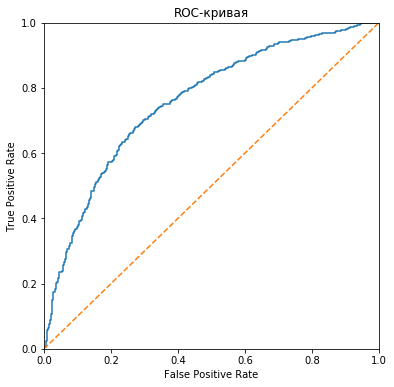

In [22]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Попробуем обучить логистическую регрессию при сбалансировании классов

AUC-ROC: 0.764219387170207


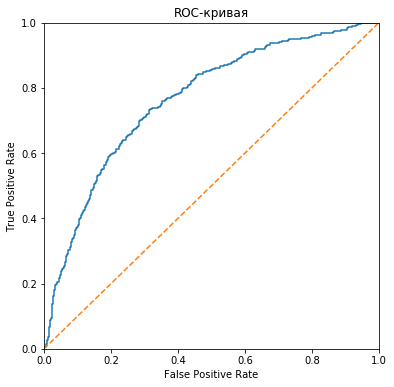

In [23]:
model_LR_balance = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_LR_balance.fit(features_train, target_train)
predictions_valid_LR_balance = model_LR_balance.predict(features_valid)

probabilities_valid_2 = model_LR_balance.predict_proba(features_valid)
probabilities_one_valid_2 = probabilities_valid_2[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_2))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_2)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Ситуация улучшилась, но незначительно. Попробуем реализоват модель с учетом дисбаланса классов.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
хороший раздел получился)

# 3. Борьба с дисбалансом

In [24]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

Определим, какую долю составляют положительные и отрицательные ответы.

In [25]:
print('Обучающая выборка','\n', target_train.value_counts() / len(target_train))
print()
print('Валидационная выборка','\n', target_valid.value_counts() / len(target_valid))

Обучающая выборка 
 0    0.795781
1    0.204219
Name: Exited, dtype: float64

Валидационная выборка 
 0    0.7865
1    0.2135
Name: Exited, dtype: float64


Как мы можем видеть у обучающей и валидационной выборок наблюдается неслабый дисбаланс классов. Ответы "0" составляют 80%, а "1" - 20%. Следовательно, для достижения баланса нам необходимо увеличить количество положительных ответов в 4 раза.

Для реализации данной идеи создадим функцию *upsample*, которая на вход будет получать три параметра. Функция вернет признаки и целевой признак после операции **upsampling**.

In [26]:
# Разделим обучающую выборку на отрицательные и положительные классы

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
# Продублируем объекты положительного класса и объеденим их с объектами отрицательного класса

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
# Перемешаем данные    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
балансировка на обучающей выборке - ОК)

In [27]:
print('Обучающая выборка','\n', target_upsampled.value_counts() / len(target_upsampled))

Обучающая выборка 
 1    0.50654
0    0.49346
Name: Exited, dtype: float64


Обучим модели на новых данных и выявим наибольшее значение **F1-меры**.

**Дерево решений**

In [28]:
model_DTC_up = DecisionTreeClassifier(random_state=12345)
model_DTC_up.fit(features_upsampled, target_upsampled)

predictions_valid_DTC_up = model_DTC_up.predict(features_valid)

preci_recall_f1(target_valid, predictions_valid_DTC_up)

Точность:  0.5
Полнота:  0.4519906323185012
F1-мера:  0.4747847478474784
AUC-ROC 0.6646475729933256


Интересно, что значение качетсва у дерева стало меньше, возможно ему больше бы подошло уменьшение выборки.

**Логистическая регрессия**

In [29]:
model_LR_up = LogisticRegression(random_state=12345, solver='liblinear')
model_LR_up.fit(features_upsampled, target_upsampled)

predictions_valid_LR_up = model_LR_up.predict(features_valid)

preci_recall_f1(target_valid, predictions_valid_LR_up)

Точность:  0.3922077922077922
Полнота:  0.7072599531615925
F1-мера:  0.504594820384294
AUC-ROC 0.7048696460022839


Показатели выросли, но этого не достаточно.

**Случайный лес**

In [30]:
model_RFC_up = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC_up.fit(features_train, target_train)
predictions_valid_RFC_up = model_RFC.predict(features_valid)
    
preci_recall_f1(target_valid, predictions_valid_RFC_up)

Точность:  0.7509727626459144
Полнота:  0.4519906323185012
F1-мера:  0.5643274853801169
AUC-ROC 0.7056520230886848


*Случайный лес* показал лучший результат, остановимся на данной модели и попробуем подобрать оптимальные гиперпараметры для улучшения качества.

In [31]:
for estimators in range(10, 110, 10):
    model_RFC_up = RandomForestClassifier(n_estimators=estimators, max_depth=11, random_state=12345)
    model_RFC_up.fit(features_upsampled, target_upsampled)

    predictions_valid_RFC_up = model_RFC_up.predict(features_valid)

    print('n_estimators: ', estimators, ':', end='')
    print(f1_score(target_valid, predictions_valid_RFC_up))

n_estimators:  10 :0.621505376344086
n_estimators:  20 :0.6323851203501093
n_estimators:  30 :0.6415929203539823
n_estimators:  40 :0.6407982261640798
n_estimators:  50 :0.6415929203539823
n_estimators:  60 :0.6365638766519823
n_estimators:  70 :0.639470782800441
n_estimators:  80 :0.6418400876232202
n_estimators:  90 :0.6454445664105378
n_estimators:  100 :0.6395604395604396


<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
Высказывание "иди ты лесом" - оказывается не такое и плохое:)

Обучим финальную модель.

In [32]:
model_final = RandomForestClassifier(n_estimators=90, max_depth=11, random_state=12345)
model_final.fit(features_upsampled, target_upsampled)
predictions_valid_final = model_final.predict(features_valid)
    
preci_recall_f1(target_valid, predictions_valid_final)

Точность:  0.6074380165289256
Полнота:  0.6885245901639344
F1-мера:  0.6454445664105378
AUC-ROC 0.7838681437787249


Проверим финальную модель на адекватность. Для этого создадим константную модель, которая любому объекту будет прогнозировать класс "0".

In [33]:
target_pred_constant = pd.Series([0] * len(target_valid))
print('Accuracy финальной модели: ', accuracy_score(target_valid, predictions_valid_final))
print('Accuracy константной модели: ', accuracy_score(target_valid, target_pred_constant))

Accuracy финальной модели:  0.8385
Accuracy константной модели:  0.7865


**Выводы**

В изначальных данных наблюдался значительный дисбаланс классов (80% отрицательных против 20% положительных), что сказывалось на качестве моделей и низком значении точности и полноты.
Методом *upsampling* мы устранили дисбаланс, увеличив количество значений позитивного класса в четыре раза и выбрали случайный лес как модель с лучшими показателями. А так же благодаря циклам подобрали наилучшие гиперпараметры. Ввиду всего этого модеь прошла тест на адекватность.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
ОК, хорошо. 

# 4. Тестирование модели

In [34]:
predictions_test = model_final.predict(features_test)
    
preci_recall_f1(target_test, predictions_test)

Точность:  0.5469613259668509
Полнота:  0.6534653465346535
F1-мера:  0.5954887218045113
AUC-ROC 0.7635098513706421


<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
отлично!!!

In [35]:
probabilities_final_model = model_final.predict_proba(features_test)
probabilities_one_final = probabilities_final_model[:, 1]
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_final))

AUC-ROC: 0.8557040746480199


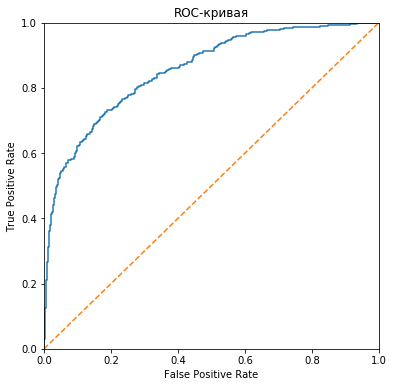

In [36]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_final)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Финальная модель достигла заданной метрики **F1** > 0.59 и показывает адекватные результаты.
С точки зрения бизнеса полученная модель поможет маркетологам лучше выявлять клиентов, которые могут уйти из банка в ближайшее время. Важно, что модель покрывает большое количество клиентов, в данном случае это важнее чем точность.

Как дополнение отметим, что для улучшения модели, возможно, следует использовать данные, отражающие отношения клиента с банком в динамике.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
<br/>Антон, добротная, качественная работа! <br>
Подготовка данных, разносторонняя работа с диссбалансом и исследование моделей и поиск параметров для них - ничего не забыто <br>
И видно, что проделана рабочая аналитическая работа: результативно и с выводами.<br>  

<font color='green'>
Если говорить, что можно ещё улучшить в подобных проектах, то я бы выделили такие моменты:<br>
1) После подбора параметров модели, когда уже настаёт этап тестировани. Можно обучить на обобщённой выборке (трайн + валидация) ну и тестировать потом. Это может ещё прибавить точности.(если не использовать кросс-валидации)<br>
    
2) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))<br> Очень ВАЖНАЯ для аналитики штука. Ведь нам не просто модель с метрикой нужна, а ещё и причины понять высокой/низкой метрики. Т.е. понять с какой силой сами факторы влияют на целевую.<br><br>
    
3) Наверное ты в курсе, просто хочу напомнить: F1 и AUC - отличные метрики, но нужно держать в голове, что это лишь бобщённые характеристики. А в реальной практике бизнесу часто важно знать детали самой ошибки - из каких ошибок/успехов она складывается. И в этом случае очень кстати будут меры полноты и точности. Рассмотри возможность их использования для своих проектов. Только через них можно выйти на финансовые возможности модели. Ведь перед запуском её в бой, будет сравнение стоимости создания и поддержки модели со стомостью "оставить как есть" <br>
    
4) предварительная работа с данными:<br>
Можно организовать для себя некую систему работы с данными:<br>
 
Например, алгоритм такой может:<br>
1) анализ аномалий: количественные и категориальные переменные <br>
2) анализ пропусков: количественные и категориальные переменные<br>
3) проверка дубликатов<br>
4) Анализ факторов: исходя из типа шкалы, могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>

<br><br>
УСПЕШНОГО ДАЛЬНЕЙШЕГО ОБУЧЕНИЯ!

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*